In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

import shutup
shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib
import matplotlib.pyplot as plt
import mediapy
from rich.pretty import pprint
from tqdm.auto import tqdm

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

# Data Collection

,,,

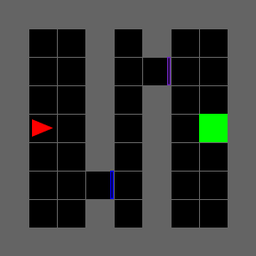
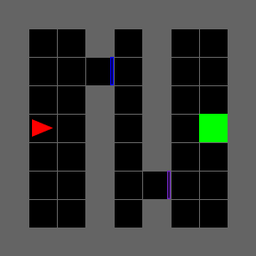
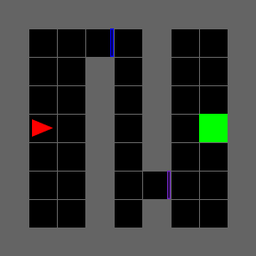
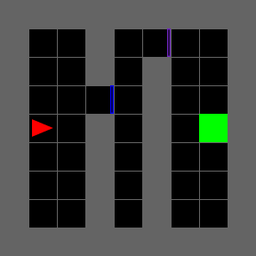

In [2]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
for i in [0, 1, 2, 3]:
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=100, task_num=0)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    env.reset()
    
    layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

  0%|          | 0/6 [00:00<?, ?it/s]

{
│   'actions': (196000,),
│   'layout_type': (196000, 6),
│   'next_observations': (196000, 2),
│   'observations': (196000, 2),
│   'terminals': (196000,)
}

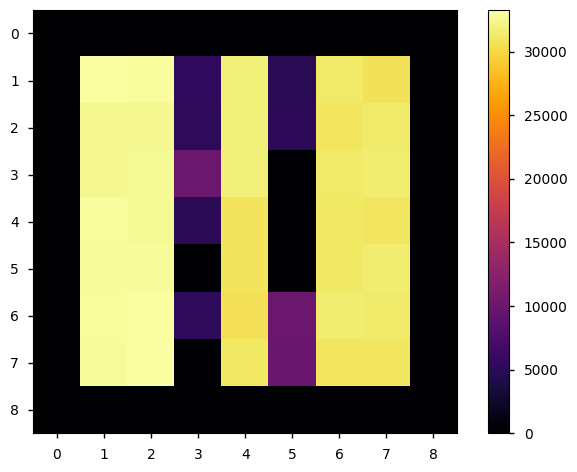

In [3]:
from envs.minigrid.env_utils import random_exploration

train_layout_data = []

NUM_TRAIN_LAYOUTS = 6
NUM_TRAIN_STEPS = 99
NUM_TRAIN_EPISODES = 2000

for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=None) # comment agent_start_pos for same start pos
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    dataset, env = random_exploration(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
    train_layout_data.append(dataset)

pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

coverage_map = np.zeros(shape=(env.env.unwrapped.width, env.env.unwrapped.height))
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

# Init FB

In [4]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_vanilla_discrete_4rooms.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)

print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 42,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 150000,
│   'log_interval': 10000,
│   'eval_interval': 30000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 100,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [1024, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'use_context': False
│   },
│   'env': {'env_name': 'fourrooms-vanilla', 'discrete': True},
│   'tags': ['vanilla-fb', '4rooms', 'discrete']
}

{'actions': (1176000,), 'layout_type': (1176000, 6), 'next_observations': (1176000, 2), 'observations': (1176000, 2), 'terminals': (1176000,)}


In [5]:
sys.path.append("..")
from agents.fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

# Train & Plot Value/Policy

AttributeError: 'DynamicsGeneralization_Doors' object has no attribute 'env'

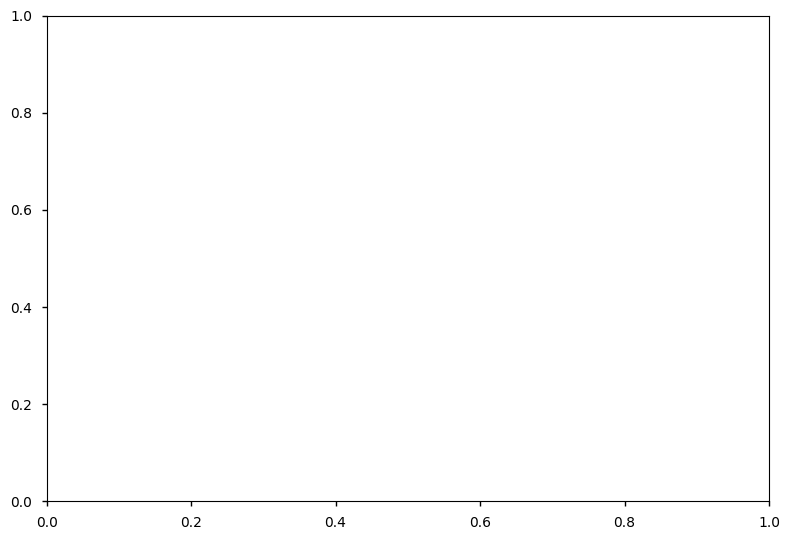

In [6]:
from functools import partial
from utils.evaluation import supply_rng
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def get_canvas_image(canvas):
    canvas.draw() 
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_grid(env, dataset, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_policy(env, dataset, fig=None, ax=None, title=None, action_fn=None, **kwargs):
    action_names = [
            r'$\leftarrow$', r'$\rightarrow$', r'$\uparrow$', r'$\downarrow$'
        ]
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    
    goal = kwargs.get('goal', None)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            action_name = action_names[action]
            ax.text(x, y, action_name, ha='center', va='center', fontsize='large', color='green')
            
    ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
    ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
        
    if title:
        ax.set_title(title)
        
    return fig, ax

def visualize_policy_image(layout_type, task_num):
    mdp_type = np.zeros((NUM_TRAIN_LAYOUTS, ))
    if mdp_type is not None:
        if layout_type == 0:
            mdp_type[0] = 1
        elif layout_type == 1:
            mdp_type[1] = 1
        else:
            mdp_type[2] = 1

    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS, task_num=task_num)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    
    latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
    example_batch = gc_whole_dataset.sample(1)
    pred_policy_img = policy_image_grid(env, example_batch,
                                                    action_fn=partial(supply_rng(fb_agent.sample_actions,
                                                                                rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z,
                                                                temperature=0.0),
                                                    goal=goal)
    return pred_policy_img

pred_policy_img = visualize_policy_image(layout_type=1, task_num=0)
plt.imshow(pred_policy_img)
plt.tight_layout()

In [10]:
env.env.unwrapped.grid

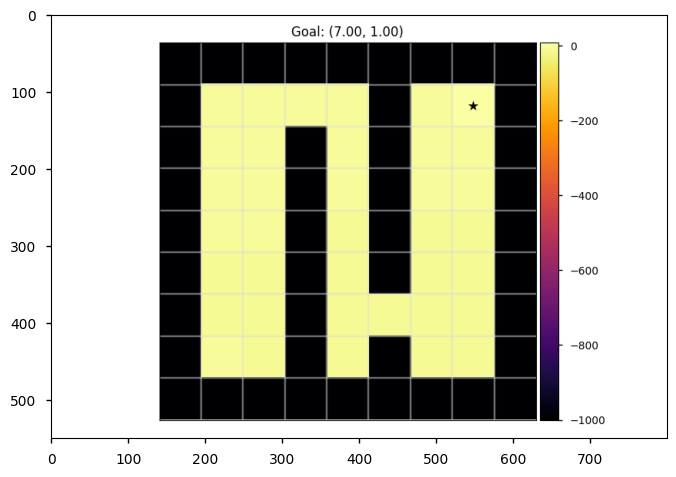

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def value_image_fourrooms(env, dataset, value_fn, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_grid(env, dataset, value_fn, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_value_image_grid(env, dataset, value_fn, action_fn, fig=None, ax=None, title=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    goal = kwargs.get('goal', None)
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)

    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            grid[y, x] = jax.device_get(value_fn(np.concatenate([[x], [y]], -1)).max(-1)[0])
            
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grid, cmap='inferno', vmin=-1000)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if goal is not None:
        ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
        ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
    return fig, ax

def visualize_value_image(layout_type, task_num):
    mdp_type = None
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS, task_num=task_num)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    
    latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
    pred_value_img = value_image_fourrooms(env, example_batch,
                                value_fn=partial(fb_agent.predict_q, z=latent_z),
                                action_fn=None, goal=goal)
    return pred_value_img

pred_value_img = visualize_value_image(2, task_num=1)
plt.imshow(pred_value_img)


In [ ]:
pbar = tqdm(range(100_000))

for update_step in pbar:
    batch = gc_whole_dataset.sample(1024)
    fb_agent, info = fb_agent.update(batch)
    
    if update_step % 5_000 == 0:
        clear_output()
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        pred_policy_img = visualize_policy_image(task_num=0)
        ax[0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(task_num=0)
        ax[1].imshow(pred_value_img)
        
        fig.suptitle(f"Training step: {update_step}")   
        plt.tight_layout()
        display(fig)
        plt.close(fig)

  0%|          | 0/100000 [00:00<?, ?it/s]

NameError: name 'clear_output' is not defined